# **Workshop 6**

In this workshop, you'll be working with KNN and AdaBoost.

## Theory Problem 1
The helper function below will help you with the first Theory problem.

In [1]:
from sklearn import metrics
import numpy as np

X = np.array([
    [-3.44, 1 ],
    [-6.48, 5],
    [0.93, -2],
    [0.2, 2],
    [-6.69, 13 ],
    [-5.85, 4],
    [3.0, 0],
    [-0.36, 0],
    [1.68, -3],
    [-0.45, -3]
    
])
np.set_printoptions(precision=2, linewidth=100, floatmode='fixed')
metrics.pairwise_distances(X)

array([[ 0.00,  5.02,  5.30,  3.77, 12.43,  3.85,  6.52,  3.24,  6.50,  4.99],
       [ 5.02,  0.00, 10.19,  7.32,  8.00,  1.18, 10.72,  7.90, 11.43, 10.02],
       [ 5.30, 10.19,  0.00,  4.07, 16.82,  9.05,  2.88,  2.38,  1.25,  1.70],
       [ 3.77,  7.32,  4.07,  0.00, 12.98,  6.37,  3.44,  2.08,  5.21,  5.04],
       [12.43,  8.00, 16.82, 12.98,  0.00,  9.04, 16.21, 14.46, 18.06, 17.17],
       [ 3.85,  1.18,  9.05,  6.37,  9.04,  0.00,  9.71,  6.79, 10.28,  8.84],
       [ 6.52, 10.72,  2.88,  3.44, 16.21,  9.71,  0.00,  3.36,  3.28,  4.57],
       [ 3.24,  7.90,  2.38,  2.08, 14.46,  6.79,  3.36,  0.00,  3.63,  3.00],
       [ 6.50, 11.43,  1.25,  5.21, 18.06, 10.28,  3.28,  3.63,  0.00,  2.13],
       [ 4.99, 10.02,  1.70,  5.04, 17.17,  8.84,  4.57,  3.00,  2.13,  0.00]])

# 0) Loading Data & Libraries

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets

# set a seed for reproducibility
random_seed = 25
np.random.seed(random_seed)

# 1) Twitter Sentiment Analysis using KNN

[Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) is the study of how we can systematically identify and quantify sentiment of a given segment of text. In this problem, you will be using the [Sentiment140](http://help.sentiment140.com/for-students/) dataset to build a classifier that will rate the sentiment of a string of text on a scale from 0 to 4.

**WARNING:** This is *real* data from *real* people from Twitter. That means you might (and probably will) see some unscrupulous language when browsing the dataset. Don't browse with kids around!

Let's take a look at our data, and what attributes we have.

* **polarity**: The assumed polarity of the tweet. For this subset, we're only considering positive and negative tweets, no neutrality.
* **id**: The tweet ID.
* **date**: The date the tweet was posted.
* **query**: The search term used in order to find tweets of a certain topic.
* **text**: The actual text of the tweet.

For now, we only consider the **polarity** and **text** attributes.

In [3]:
train_data = pd.read_csv("./data/train_reduced.csv")

In [4]:
train_data.head()

,polarity,id,date,query,user,text
0,4,1468251446,Tue Apr 07 00:33:05 PDT 2009,NO_QUERY,derek319,www.killerjo.net try not to focus on science
1,4,2052426181,Sat Jun 06 00:41:22 PDT 2009,NO_QUERY,DJSunshine1980,"After Rain following often the Sun, so don't b..."
2,4,1692413347,Sun May 03 19:56:39 PDT 2009,NO_QUERY,MicheleBlueston,@Sixtiesguy Hey it's sexy to be unemployed...a...
3,4,2176577445,Mon Jun 15 04:14:20 PDT 2009,NO_QUERY,is_selene,NVM. Thank god for auto recovery. I didn't los...
4,4,1771234509,Mon May 11 23:38:42 PDT 2009,NO_QUERY,STARj0NES314,@IamSpectacular damn like dat ? hahaha


In [5]:
# Check our disribution of polarity
# 4 means postive sentiment
# 0 means negative sentiment
train_data.polarity.value_counts()

4    345223
0    344777
Name: polarity, dtype: int64

## 1.1) Brief Introduction to tf-idf (Follow)
In information retreival [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (*term frequency – inverse document frequency*) is a metric that represents how "important" a word is to a corpus of text. While we won't go into detail about how it works, essentially all you need to know is that it balances two metrics.

**Term Frequency**: Is exactly what one would expect, it is the the frequency at which a word is present in a corpus of text. A word with a higher term-frequency score appears much more in the corpus compared to one with a low term frequency.

**Inverse Document Frequency**: If we only used term frequency, common words like "the" or "and" would have a high score, even though they don't give us that much information since they are present in every document. *Inverse Document Frequency* is a metric of how much "information" a word provides, and if a word is common or rare across all documents.

### tf-idf with sklearn

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?'
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.shape)

(4, 9)


The tf-idf vectorizer's `fit_transform` method returns a NxM matrix. `N` is the number of documents (sentences) you have in your corpus, and `M` is the number of unique words in your corpus. Item `n`x`m` is how important word `m` is to document `n`.

In [7]:
# Printing out the tf-idf matrix
np.set_printoptions(precision=4)
print(X.toarray())

[[0.0000 0.4698 0.5803 0.3841 0.0000 0.0000 0.3841 0.0000 0.3841]
 [0.0000 0.6876 0.0000 0.2811 0.0000 0.5386 0.2811 0.0000 0.2811]
 [0.5118 0.0000 0.0000 0.2671 0.5118 0.0000 0.2671 0.5118 0.2671]
 [0.0000 0.4698 0.5803 0.3841 0.0000 0.0000 0.3841 0.0000 0.3841]]


In [8]:
# Notice that if we try and print X directly, we get an overview saying that X is a "sparse matrix".
# In very large corpi with many unique words, a lot of row entries are going to consist of majority zeros
# Thus numpy saves theses in a special compressed sparse format
X

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [9]:
# Next let's see what word each column corresponds to:
vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

Let's look at the tf-idf vectors for two different documents.

**Note**: `dic(zip(A, B))` in pyton makes a dictionary out of a list of keys (A) and values (B). This just makes it easier to view each term with it's corresponding TFIDF value.

In [10]:
print(corpus[0])
dict(zip(vectorizer.get_feature_names(),X.toarray()[0]))

This is the first document.


{'and': 0.0,
 'document': 0.46979138557992045,
 'first': 0.5802858236844359,
 'is': 0.38408524091481483,
 'one': 0.0,
 'second': 0.0,
 'the': 0.38408524091481483,
 'third': 0.0,
 'this': 0.38408524091481483}

In [11]:
print(corpus[1])
dict(zip(vectorizer.get_feature_names(),X.toarray()[1]))

This document is the second document.


{'and': 0.0,
 'document': 0.6876235979836938,
 'first': 0.0,
 'is': 0.281088674033753,
 'one': 0.0,
 'second': 0.5386476208856763,
 'the': 0.281088674033753,
 'third': 0.0,
 'this': 0.281088674033753}

Take a look at the tf-idf vectors for both of these sentences and answer the following questions:
1. Why is the value for the term "is" higher in document1 than document2?
2. Why is the value for the term "document" higher in document2 than document1?

**Discuss Here**

## 1.2) Model Design Discussion (Group)

Now that you're aware of what tf-idf scores are, **discuss with your group on how you could use tf-idf to build a KNN classifier**:
1. If the data objects (rows) each represent a tweet, what would the features (columns) of the dataset be?
2. How would you represent a single tweet as a vector of numbers (values for each of the features)? What would it mean to have a value of 0 for a given feature? What about 0.4?
3. What would it mean for two sentences to be "nearest neighbors"?
4. Would you expect two near neighbors to have similar sentiment? Why or why not?

**Discuss Here**

1. Text is the best feature column because it's the content or text of the tweet.
1. Then its the frequency of the word
1. They have words in common, so they are near each other in the vector space.
1. No, just similar words, computer dosent know tone.

## 1.3) tf-idf on Twitter (Follow)

Now, before we build a classifier, let's just try and see what the nearest neighbors of a specified message are.

In [12]:
# Get our text
corpus = train_data["text"]

In [13]:
# Run our transform
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()
tfidf_matrix = tf.fit_transform(corpus)

In [14]:
# Let's check the size of our matrix
tfidf_matrix

<690000x387729 sparse matrix of type '<class 'numpy.float64'>'
	with 8185910 stored elements in Compressed Sparse Row format>

Now, let's fit the nearest neighbors tree!

In [15]:
# Fit your KNN model
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(tfidf_matrix)

We can now run custom sentences and see what sentences in the corpus are "closest" to what we put in. Try a few and see what shows up! In addition to this, you can change the `n_neighbors` param and get more queries.

In [16]:
# Test a tweet!
test_docs = ["I sure love paying my taxes!"]
test_docs = tf.transform(test_docs)
distances, indicies = nbrs.kneighbors(test_docs)
train_data.iloc[indicies[0]]

,polarity,id,date,query,user,text
617716,0,2265303137,Sun Jun 21 06:16:29 PDT 2009,NO_QUERY,beesjebinda,Doing our taxes
124623,0,2194131231,Tue Jun 16 09:23:08 PDT 2009,NO_QUERY,HeyKirby,I don't wanna pay taxes
100946,0,1467813137,Mon Apr 06 22:20:25 PDT 2009,NO_QUERY,armotley,about to file taxes
484942,0,1551900745,Sat Apr 18 10:15:56 PDT 2009,NO_QUERY,Slushie76,working on taxes and marks...
550210,0,2215612962,Wed Jun 17 18:22:36 PDT 2009,NO_QUERY,nathanbraceros,Thinking about taxes. How depressing!


In [17]:
test_docs = ["let's play DnD "]
test_docs = tf.transform(test_docs)
distances, indicies = nbrs.kneighbors(test_docs)
train_data.iloc[indicies[0]]

,polarity,id,date,query,user,text
505723,0,1985240146,Sun May 31 16:42:51 PDT 2009,NO_QUERY,cutekiwi,Wishes it was dnd week
435832,0,1963236303,Fri May 29 12:25:00 PDT 2009,NO_QUERY,kkelss,Ugh! I wanna play dnd but i know i'm going to ...
59813,0,2209772354,Wed Jun 17 10:46:44 PDT 2009,NO_QUERY,Kristin428,Horrible migraine today. Might have to cancel ...
672042,0,2175603421,Mon Jun 15 01:27:33 PDT 2009,NO_QUERY,ruth_ie,DND I have a migrain...i think my head might e...
64275,0,2044129048,Fri Jun 05 08:54:45 PDT 2009,NO_QUERY,goctopus,WHY WON'T IT LET ME PLAY?


In [18]:
test_docs = ["Keeping my house clean"]
test_docs = tf.transform(test_docs)
distances, indicies = nbrs.kneighbors(test_docs)
train_data.iloc[indicies[0]]

,polarity,id,date,query,user,text
329867,4,1677327631,Sat May 02 01:30:56 PDT 2009,NO_QUERY,kinia1245,Clean my house
169334,4,1827698955,Sun May 17 11:15:37 PDT 2009,NO_QUERY,idyllicwater,Clean house
641029,0,1994424844,Mon Jun 01 11:54:16 PDT 2009,NO_QUERY,luckypiano1996,have to clean the house
237226,0,2194627321,Tue Jun 16 10:02:53 PDT 2009,NO_QUERY,burnett4923,Really need to clean my house
610328,0,2054604053,Sat Jun 06 07:42:35 PDT 2009,NO_QUERY,kaylaspiveyy,gotta clean the house.


Now discuss together:
1. Try manually classifying the tweet "Wow, this is so cool!" What are the classes of the neighbors? How would a 5-NN classifier classify that tweet?
2. Can you think of a tweet that might fool this classifier? For example, how would it do with sarcasm?

## 1.4) Building and Evaluating the Classifier (Group)

Now, your goal is to use the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) in order to build an actual classifier for the sentiment dataset. Build the classifier with a `k=5`, and then evaluate it on the test data. Print the confusion matrix and a classification report, and interpret the evaluation metrics. Remember, a class label of `0` means a negative sentiment, and a class label of `1` means a positive sentiment.

In [19]:
test_data = pd.read_csv("./data/test_reduced.csv")

In [20]:
test_data.head()

,polarity,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [22]:
# Get your X features (text) and y labels (polarity) for the test set
# Transform the X features into TFIDF vectors
from sklearn.model_selection import train_test_split
test_data_fraction = 0.2
y = test_data["polarity"]
corpus = test_data["text"]
tf = TfidfVectorizer()
tfidf_matrix = tf.fit_transform(corpus)

X_train, X_test, Y_train, Y_test = train_test_split(tfidf_matrix, y, test_size=test_data_fraction,  random_state=random_seed)

In [23]:
# Train your KNN model with k=5
nbrs = KNeighborsClassifier(n_neighbors=5)
nbrs.fit(X_train, Y_train)

KNeighborsClassifier()

In [24]:
# Print a confusion matrix of the predictions
from sklearn.metrics import confusion_matrix
predict = nbrs.predict(X_test)
confusion_matrix(Y_test, predict)

array([[25, 11],
       [ 3, 33]])

In [25]:
# Use the classification_report to report how well your model did
print(classification_report(Y_test,predict))

              precision    recall  f1-score   support

           0       0.89      0.69      0.78        36
           4       0.75      0.92      0.83        36

    accuracy                           0.81        72
   macro avg       0.82      0.81      0.80        72
weighted avg       0.82      0.81      0.80        72



Now, discuss with your group about your results.
1. How well do you think the classifier performed overall?
2. Can you find some examples of test instances that were not accurately classified? Based on their nearest neighbots in the training dataset, why do you think they were hard to classify?
3. We represented each tweet using TF-IDF, representing the frequency of individual words. What other types of features might be important for predicting the sentiment of a tweet?

In [28]:
#From class "Travis Martin"
X = test_data["text"]
X = tf.transform(X)
y_true = test_data["polarity"]
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(tfidf_matrix, test_data["polarity"])
predictions = neigh.predict(X)
confusion_matrix(y_true,predictions)


array([[149,  28],
       [ 18, 164]])

In [43]:
print(classification_report(y_true,predictions))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       177
           4       0.73      0.71      0.72       182

    accuracy                           0.72       359
   macro avg       0.72      0.72      0.72       359
weighted avg       0.72      0.72      0.72       359



**Discuss your results here.** 

# 2) AdaBoost

In this exercise, you'll be learning how to use [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), as well as vizualize decision boundries.

## 2.1) Using AdaBoost (Follow/Group)

In [29]:
# Read the iris dataset and translate to pandas dataframe
bc_sk = datasets.load_breast_cancer()
# Note that the "target" attribute is species, represented as an integer
bc_data = pd.DataFrame(data= np.c_[bc_sk['data'], bc_sk['target']],columns= list(bc_sk['feature_names'])+['target'])

In [30]:
from sklearn.model_selection import train_test_split
# The fraction of data that will be test data
test_data_fraction = 0.10

bc_features = bc_data.iloc[:,0:-1]
bc_labels = bc_data["target"]
X_train, X_test, Y_train, Y_test = train_test_split(bc_features, bc_labels, test_size=test_data_fraction,  random_state=random_seed)

First, let's have a baseline non-boosted decision tree to compare against.

In [31]:
from sklearn.tree import DecisionTreeClassifier
gini_tree = DecisionTreeClassifier(criterion = "gini", random_state=random_seed).fit(X=X_train, y=Y_train)

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
predicted_y = gini_tree.predict(X_test)

In [33]:
print(classification_report(predicted_y,Y_test))

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        20
         1.0       0.92      0.92      0.92        37

    accuracy                           0.89        57
   macro avg       0.88      0.88      0.88        57
weighted avg       0.89      0.89      0.89        57



In [34]:
confusion_matrix(predicted_y,Y_test)

array([[17,  3],
       [ 3, 34]])

In [35]:
from sklearn.ensemble import AdaBoostClassifier

Now, let's get boosting. The default estimator for AdaBoost is a *decision stump*. (Remember: a decision stump is simply a decision tree with a height of 1).

In [56]:
# Fit the Adaboost classifier 
adaboost = AdaBoostClassifier(n_estimators=50, random_state=random_seed)
adaboost.fit(X_train, Y_train)

AdaBoostClassifier(random_state=25)

In [57]:
# predict the labels for the test data
predicted = adaboost.predict(X_test)

In [58]:
# print its performance
print(classification_report(predicted,Y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        20
         1.0       0.97      0.97      0.97        37

    accuracy                           0.96        57
   macro avg       0.96      0.96      0.96        57
weighted avg       0.96      0.96      0.96        57



In [59]:
# print the confusion matrix
confusion_matrix(predicted,Y_test)

array([[19,  1],
       [ 1, 36]])

As we can see, the boosted model performs better.

Now, what happens when we put a more complex model into AdaBoost? Let's say, for this example, each component model is a full decision tree with no size limits.

What do you expect will happen? Why? Discuss.

**Discuss here**

In [43]:
# Try training a boosted model with full decision trees (no pruning)
gini_tree = DecisionTreeClassifier(criterion = "gini", random_state=random_seed)
bdt = AdaBoostClassifier(base_estimator=gini_tree,n_estimators=20,random_state=random_seed)
bdt.fit(X_train,Y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=25),
                   n_estimators=20, random_state=25)

In [44]:
predicted_y = bdt.predict(X_test)

In [45]:
print(classification_report(predicted_y,Y_test))

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        20
         1.0       0.92      0.92      0.92        37

    accuracy                           0.89        57
   macro avg       0.88      0.88      0.88        57
weighted avg       0.89      0.89      0.89        57



In [46]:
confusion_matrix(predicted_y,Y_test)

array([[17,  3],
       [ 3, 34]])

Were the results what you expected? If they weren't, why not? Discuss.

becasue it overfit.

**Discuss Here**

## 2.2) Visualizing Decision Boundries (Group)

Now, we're going to peek under the hood and see the decision boundries of ensemble learners.

In [60]:
import math
from sklearn.datasets import make_moons

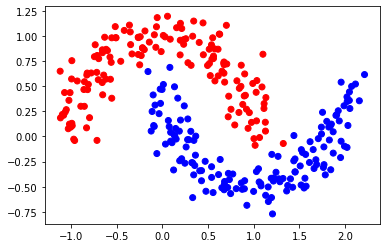

In [61]:
# A nice noisy dataset that's not linearly separable
X,y = make_moons(300, noise=0.13,random_state = random_seed)
colors = {0:'red',1:"blue"}
plt.scatter(X[:,0],X[:,1],c=np.vectorize(colors.get)(y))

You're given some code to calculate Adaboost by hand below, but for it to work, you need to complete the following helper functions.

In `calculate_alpha`, you should calculate alpha for the round, based on the classifier's predictions and the weights of that round. The basic steps are:
1. Calculate the **weighted** error $\epsilon$ for the round by comparing those predictions to y. Remember, the error is the sum of the weights of misclassified instances.
2. Calculate alpha using the following formula:

$$\alpha = 0.5*ln(\frac{1 - \epsilon}{\epsilon})$$

In [70]:
def calculate_alpha(predictions, weights, y):
    """
    Inputs:
        predictions: the predictions (0 or 1) of the classifier in this round.
        weights: the weights of each instance at the end of last round
        y: the class labels (0 or 1) for the instances
    Output: the alpha value for this round
    """
    error = sum(np.take(weights, np.where(predictions != y)[0]))
    alpha = 0.5 * math.log((1 - error) / error)
    return alpha


In [71]:
# To test calculate_alpha, we need to make a decision tree and some starting weights
dt = DecisionTreeClassifier(criterion = "gini", max_depth=1, random_state=123).fit(X, y)
predictions = dt.predict(X)
weights = np.repeat(1 / len(X), len(X))
# Alpha should be ~0.84
alpha = calculate_alpha(predictions, weights, y)
np.testing.assert_almost_equal(alpha, 0.8416209435087314)
alpha

0.8416209435087314

Next you need to write a function that will update the weights for the adaboost classifier based on the alpha value. Remember:
* Correctly classified instances have their weight decreased.
* Incorrectly classified instances have their weight increased.

The amount by which the weight changes is $e^\alpha$.

**Note**: You do not need to normalize the weights to sum to 1 - the code below will do that for you.

In [98]:
import math
def update_weights(predictions, weights, y, alpha):
    """
    Inputs:
        predictions: the predictions (0 or 1) of the classifier in this round.
        weights: the weights at the end of the previous round for each instance
        y: the class labels (0 or 1) for the instances
        alpha: the alpha value for this round
    Output: an array of updated weights for this round
    """
    new_weights = []
    for index, value in enumerate(predictions):
        if predictions[index] == y[index]:
            new_weights.append(weights[index] / np.exp(alpha))
        else:
            new_weights.append(weights[index] * np.exp(alpha))

    # BEGIN SOLUTION
    return new_weights

In [99]:
weights = np.repeat(1 / len(X), len(X))
new_weights = update_weights(predictions, weights, y, alpha) 
alpha = 0.8416209435087314
print(new_weights)
np.testing.assert_almost_equal(max(new_weights), 1/300*math.exp(alpha))
np.testing.assert_almost_equal(min(new_weights), 1/300/math.exp(alpha))

[0.002590921000728165, 0.0042884793121783305, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.0042884793121783305, 0.002590921000728165, 0.0042884793121783305, 0.0042884793121783305, 0.002590921000728165, 0.002590921000728165, 0.0042884793121783305, 0.0042884793121783305, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.0042884793121783305, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.0042884793121783305, 0.0042884793121783305, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.002590921000728165, 0.0042884793121783305, 0.002590921000728165, 0.002590921000728165,

AssertionError: 
Arrays are not almost equal to 7 decimals
 ACTUAL: 0.0042884793121783305
 DESIRED: 0.007733749071730463

Here's our code for Adaboost. You don't have to modify it, just finish the functions above.

Why are we implementing it by hand? This way we can keep track of which samples were chosen each round to visualize them.

When you run the following code, you can see the alpha values for each round, changing as the weights, and therefore the samples, change.

In [101]:
# Let's do 20 rounds of adaboost
rounds = 20
# N is the length of training data
N = len(X)
# Each boostrapped sample will b size N/5
sample_size = N // 5

# Each round, keep track of:
# Which instances (indices) were samples
sample_indices = []
# The classifier built on that sample
dtrees = []
# The alpha value for each that round
alphas = []

# Start our weights off each as 1/N
weights = np.repeat(1 / N, N)

for i in range(rounds):
    indices = np.random.choice(range(N), sample_size, replace=True, p=weights)
    sample_X = X[indices,:]
    sample_y = y[indices]
    # Train a simple decision tree on the sample
    dt = DecisionTreeClassifier(criterion = "gini", max_depth=1).fit(sample_X, sample_y)
    predictions = dt.predict(X)
    
    # Calculate alpha
    alpha = calculate_alpha(predictions, weights, y)
    print(f'Round {i} Alpha: {alpha}')
    
    # Update weights
    weights = update_weights(predictions, weights, y, alpha)
    weights /= sum(weights)
    
    sample_indices.append(indices)
    alphas.append(alpha)
    dtrees.append(dt)

Round 0 Alpha: 0.7928136318701916
Round 1 Alpha: 0.5469465363682309
Round 2 Alpha: 0.6429179143870936
Round 3 Alpha: 0.6251280327206902
Round 4 Alpha: 0.3006326853083269
Round 5 Alpha: 0.5179054523681129
Round 6 Alpha: 0.44532797815721875
Round 7 Alpha: 0.4390987328314619
Round 8 Alpha: 0.44887991040049147
Round 9 Alpha: 0.4642225837715488
Round 10 Alpha: 0.3937108231484455
Round 11 Alpha: 0.40633873917029784
Round 12 Alpha: 0.4363872727701348
Round 13 Alpha: 0.4352095137208956
Round 14 Alpha: 0.37052030872441827
Round 15 Alpha: 0.2193616149790241
Round 16 Alpha: 0.4775130198601403
Round 17 Alpha: 0.31327305996183724
Round 18 Alpha: 0.3136466677985405
Round 19 Alpha: 0.49721621410497585


In [102]:
# This function makes predictions for a given list of X features by taking the weighted sum of
# its constituent classifiers' predictions.
def boosting_predict(X_test):
    return np.mean([(dtrees[i].predict(X_test) - 0.5) * alphas[i] for i in range(len(dtrees))], axis=0) + 0.5

In [103]:
# Based on the image above, how should points (0, 0) and (1, 1) be classified?
# Note that the output is continuous: > 0.5 means more likely to be 1.
boosting_predict([[0, 0], [0, 1]])

array([0.5576, 0.4485])

The following code will plot the predictions from individual rounds of adaboost. Note:
* The background color indicates the prediction.
* The faded dots were *not* sampled in this round (e.g. because of their low weights).

In [106]:
# Here is a provided method that will plot the decision boundries of each stump

def plot_predictions(pred_function, sample_indices, subplot=plt, continuous=False):
    plot_colors = "br"
    plot_step = 0.02
    class_names = "AB"

    #

    # Plot the decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = pred_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if not continuous:
        Z = np.round(Z)
        cs = subplot.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    else:
        cs = subplot.contourf(xx, yy, Z)

    # Plot the training points
    for i, n, c in zip(range(2), class_names, plot_colors):
        idx = np.where(y == i)
        in_sample_idx = np.intersect1d(idx, sample_indices)
        subplot.scatter(X[in_sample_idx, 0], X[in_sample_idx, 1],
                    c=c, cmap=plt.cm.Paired,
                    s=20, edgecolor='k',
                    label="Class %s (Sampled)" % n)
        out_sample_idx = np.setdiff1d(idx, in_sample_idx)
        subplot.scatter(X[out_sample_idx, 0], X[out_sample_idx, 1],
                    c=c, cmap=plt.cm.Paired,
                    s=20, edgecolor='k', alpha=0.1,
                    label="Class %s (Not Sampled)" % n)


Now we plot the first 12 rounds of adaboost:

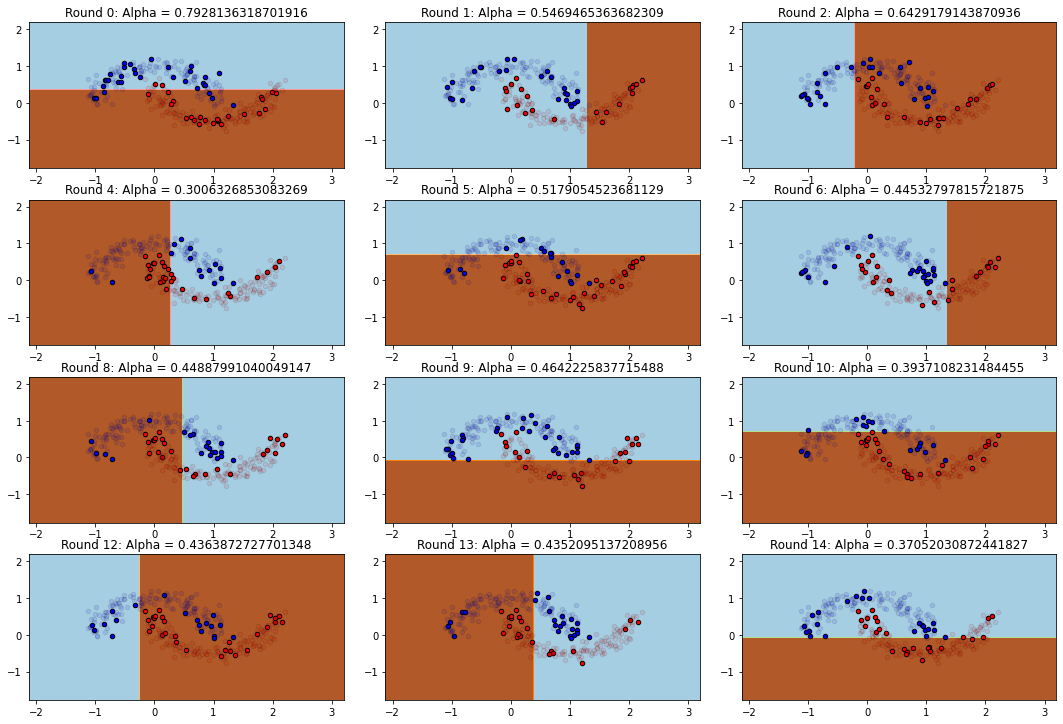

In [107]:
rows = 4
cols = 3

figure, axis = plt.subplots(rows, cols, figsize=(15, 10))
figure.tight_layout()

for i in range(rows):
    for j in range(cols):
        idx = i*rows + j
        subplot = plot_predictions(dtrees[idx].predict, sample_indices[idx], axis[i,j])
        axis[i,j].title.set_text(f'Round {idx}: Alpha = {alphas[idx]}')

plt.show()

Now answer the following questions:
1. Which rounds are most important to the classification? What do they have in common?
2. Do you notice any changes in the samples (and resulting classifiers) in later rounds of Adaboost?

1. Small alpha, rounf 4
1. Edges, when they cut to make the model.  -- The whole model will be the compilation/merging of the edges.

**Answer here**

Finally, we can plot the whole adaboost classifier. Note the non-linear decision boundary.
* The first plot shows the discrete boundary, comprised of all of the above weak classifiers.
* The second plot shows the same prediction as a continuous boundary.

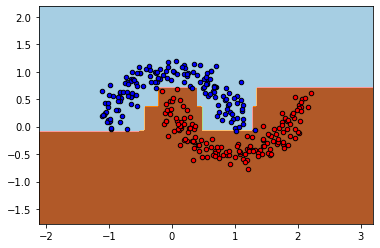

In [108]:
plot_predictions(boosting_predict, range(len(X)), plt)

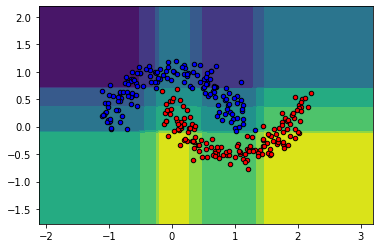

In [109]:
plot_predictions(boosting_predict, range(len(X)), plt, continuous=True)

Now answer the following questions:
1. How can Adaboost create a non-linear boundary to accurately classify this shape?
2. Which areas of the plot is the classifier most certain about, or least certain?

**Answer Here**

1. yes it can.
1. Where alph is closer to 0 it is more certain.